# Machine Learning Capstone Project

## TalkingData AdTracking Fraud Detection Challenge

----------------------------------

### 1. Project Overview

With the latest web technologies there are many new avenues that are opened for the mankind. There are Millions of companies across the Globe that are providing varied services including Domain Registration, Online Gaming, Web Hosting, Cab Booking, Food Ordering, Health Consultation, Online Advertising and lot more. Many of these services makes our life very easy but at the same time we can easily become a victim of a fraud if we are not careful. One of the frauds that is related to Online Advertising is "Click Fraud". Click fraud is a type of fraud that occurs on the Internet in Pay-Per-Click (PPC), Pay-Per-Action (PPA) or Cost-Per-Activity (CPA) online advertising. In this type of advertising, the websites owners that post the ads are paid an amount of money determined by how many visitors to the sites or mobile app click on the ads. Fraud occurs when a person, automated script or computer program imitates a legitimate user clicking on such an ad without having an actual interest in the target of the ad's link.

### 2. Problem Statement

One of the major areas of "Click Fraud" is in the area of mobile ad channels where automated scripts may click mobile ads or download a mobile app without a real reason. The problem that we will be solving here is to predict if a user click is genuine or fraudulent. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fraudulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps.

So, here we have to build an algorithm that predicts whether a user will download an app after clicking a mobile app Ad.

### 3. Datasets and Inputs

To build an algorithm that predicts whether a user will download an app after clicking a mobile app ad TalkingData has provided us a generous dataset covering approximately 200 million clicks over 4 days.

**File descriptions**

- train.csv - The training set consisting of approximately 200 Million rows
- train_sample.csv - 100,000 randomly-selected rows of training data
- test.csv - the testing set consisting of approximately 20 Million rows

**Data fields**

Each row of the training data contains a click record, with the following features:

- ip: IP Address of click.
- app: App id for marketing.
- device: Device type id of user mobile phone (e.g., iPhone 6 Plus, iPhone 7, Huawei mate 7, etc.)
- os: OS version id of user mobile phone
- channel: Channel id of mobile ad publisher
- click_time: Timestamp of click (UTC)
- attributed_time: If user download the app for after clicking an ad, this is the time of the app download
- is_attributed: The target that is to be predicted, indicating the app was downloaded

### 4. Evaluation Metrics

As the submissions are evaluated on area under the ROC curve between the predicted probability and the observed target we will also use the same metric.

A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.

### 5. Load Required Libraries

In [112]:
# Load required libraries
import os
import subprocess
import gc
import random

import sqlite3
import zipfile

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import lightgbm as lgb

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
random.seed(2018)

### 6. Train and Test File Details

In [114]:
# Read the Train and Test files
zf_train = zipfile.ZipFile('train.csv.zip', mode='r')
zf_test = zipfile.ZipFile('test.csv.zip', mode='r')

In [115]:
# Print details of the Train csv file.
for info in zf_train.infolist():
    print("File Name         -> {}".format(info.filename))
    print("Compressed Size   -> {:.2f} {}".format(info.compress_size/(1024*1024), "MB"))
    print("UnCompressed Size -> {:.2f} {}".format(info.file_size/(1024*1024), "MB"))

File Name         -> mnt/ssd/kaggle-talkingdata2/competition_files/train.csv
Compressed Size   -> 1238.43 MB
UnCompressed Size -> 7188.46 MB


In [116]:
# Print details of the Test csv file.
for info in zf_test.infolist():
    print("File Name         -> {}".format(info.filename))
    print("Compressed Size   -> {:.2f} {}".format(info.compress_size/(1024*1024), "MB"))
    print("UnCompressed Size -> {:.2f} {}".format(info.file_size/(1024*1024), "MB"))

File Name         -> test.csv
Compressed Size   -> 161.93 MB
UnCompressed Size -> 823.28 MB


As we see above, we have a very huge train file that has an UnCompressed Size of around 7.2GB and compressed file is around 1.2GB. Also the test file is around 823MB uncompressed and after compression comes to around 162MB.

In [117]:
# Print records in train.csv
with open('train.csv') as f:
    size=len([0 for _ in f])
    print("Records in train.csv => {}".format(size))

Records in train.csv => 184903891


In [118]:
# Print records in test.csv
with open('test.csv') as f:
    size=len([0 for _ in f])
    print("Records in test.csv => {}".format(size))

Records in test.csv => 18790470


As can be seen from the above output, we have around **184.9 Million** rows in the train set and **18.8 Million** rows in the test set.

As it is very difficult to work on the complete training data, we will use the last **25 Million** rows from the training set and build a model.

### 7. Analyze Feature Data Types

Before we go ahead and read the training data we will take a look at the "train_sample.csv" file provided by the organizers.

In [119]:
train_sample = pd.read_csv("train_sample.csv")
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [120]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


As the data is huge we could do a simple optimization to effectively use our memory. We know that Python uses its best of knowledge to decide on the data types and might allocate a higher size data type than really required, say int64 instead of unit16.

A simple step that we will be doing here is to **sqlite3** to build a database file from the train.csv and analyze the data in each of the coulmns. With this information we will be able to decide on the best data type for each of the features.

```
con = sqlite3.connect("talkingdata_train.db")  # Opens file if exists, else creates file
cur = con.cursor()  # This object lets us actually send messages to our DB and receive results

sql = "SELECT sql FROM sqlite_master WHERE name='test_data'"
cur.execute(sql)

if not cur.fetchall():
    for chunk in pd.read_csv("train.csv", chunksize=5000):
        chunk.to_sql(name="train_data", con=con, if_exists="append", index=False)  #"name" is name of table
        gc.collect()

# Below SQL queries can be used to get the min and max values for each of the features


Below we will print the max and min values for the ip column in the train_data table. The actual results returned for this query on the complete train data is (1, 364778). This values will help us to choose a datatype for this column when loading the data in to a pandas DataFrame. So, for ip we can choose uint32

sql = "select min(ip), max(ip) from train_data"
cur.execute(sql)
cur.fetchall()

Below we will print the max and min values for the app column in the train_data table. The actul results returned for this query on the complete train data is (0, 768). This values will help us to choose a datatype for this column when loading the data in to a pandas DataFrame. So, for app we can choose uint16

sql = "select min(app), max(app) from train_data"
cur.execute(sql)
cur.fetchall()

Below we will print the max and min values for the device column in the train_data table. The actul results returned for this query on the complete train data is (0, 4227). This values will help us to choose a datatype for this column when loading the data in to a pandas DataFrame. So, for device we can choose uint16

sql = "select min(device), max(device) from train_data"
cur.execute(sql)
cur.fetchall()

Below we will print the max and min values for the os column in the train_data table. The actul results returned for this query on the complete train data is (0, 956). This values will help us to choose a datatype for this column when loading the data in to a pandas DataFrame. So, for os we can choose uint16

sql = "select min(os), max(os) from train_data"
cur.execute(sql)
cur.fetchall()

Below we will print the max and min values for the channel column in the train_data table. The actul results returned for this query on the complete train data is (0, 500). This values will help us to choose a datatype for this column when loading the data in to a pandas DataFrame. So, for channel we can choose uint16

sql = "select min(channel), max(channel) from train_data"
cur.execute(sql)
cur.fetchall()

Below we will print the max and min values for the is_attributed column in the train_data table. The actul results returned for this query on the complete train data is (0, 1). This values will help us to choose a datatype for this column when loading the data in to a pandas DataFrame. So, for is_attributed we can choose uint8

sql = "select min(is_attributed), max(is_attributed) from train_data"
cur.execute(sql)
cur.fetchall()

```

Below we will see what percentage of data is attributed.

```
Below we will get the records where the value of is_attributed is 1. For the actual data we can see that this value is 456846 which means that we have only 0.247 % of records where is_attributed is 1.

sql = "select count(*) from train_data where is_attributed=1"
cur.execute(sql)
cur.fetchall()
```

As can be seen from the above information we have a very highly imbalanced data set.

In [121]:
# Data types of each of the features are chosen based on the value range instead of relying on the python interpreter.
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

### 8. Read Train and Test Data

In [169]:
# Read the last 25 Million records from training data
train_df = pd.read_csv("train.csv", skiprows=range(1,159903891), nrows=25000000, dtype=dtypes)
train_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,33748,18,1,10,134,2017-11-09 08:15:22,NaN,0
1,26810,3,1,25,489,2017-11-09 08:15:22,NaN,0
2,105587,21,1,13,128,2017-11-09 08:15:22,NaN,0
3,3542,2,1,13,435,2017-11-09 08:15:22,NaN,0
4,124339,3,1,41,211,2017-11-09 08:15:22,NaN,0


In [170]:
# Check if there are any NaN values in the Train DF
train_df.columns[train_df.isnull().any()].tolist()

['attributed_time']

**attributed_time** is set when the **is_attributed** field is True. This is the time when an App was actually downloaded after an Ad was clicked.

In [171]:
# Read the records from test data
test_df = pd.read_csv("test.csv", dtype=dtypes)
test_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [172]:
# Check if there are any NaN values in the Test DF
test_df.columns[test_df.isnull().any()].tolist()

[]

It's good to see that there are no NaN values in either the Train or Test DF.

In [173]:
train_df.nunique()

ip                 91647
app                  435
device              1905
os                   396
channel              182
click_time         27879
attributed_time    24540
is_attributed          2
dtype: int64

### 9. Naive Model

Before we do any feature engineering, we will use the features like 'ip', 'app', 'device', 'os' and 'channel' to build a naive model.

In [127]:
train_naive_df = train_df[['ip', 'app', 'device', 'os', 'channel', 'is_attributed']]

X_train_naive, X_test_naive = train_test_split(train_naive_df, test_size=0.3)

X_train = X_train_naive.drop(['is_attributed'], axis=1)
y_train = X_train_naive['is_attributed']

X_test = X_test_naive.drop(['is_attributed'], axis=1)
y_test = X_test_naive['is_attributed']

In [128]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [208]:
y_pred = rf.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)

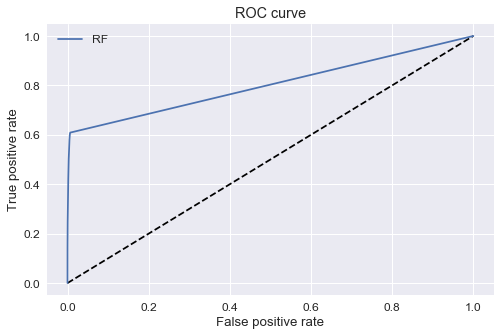

In [209]:
# Plot the ROC Curve
plt.figure(1)
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

As we can see from the above plot, the naive model is slightly better than the very basic prediction. We will do feature engineering to build new features and improve the prediction score.

### 10. EDA

Below we will print the unique IP addresses in the 25M records.

In [131]:
print(len(train_df['ip'].unique()))

91647


So, there are a total of 91,647 different IP addresses present in the last 25M records. This means that there are multiple clicks from each of the IP addresses.
Below we will see the details of IP addresses from where the top clicks have been generated.

In [132]:
print(pd.value_counts(train_df['ip'])[:20])

5348      239729
5314      212599
73516     116306
73487     114722
112302    105973
17149      87190
53454      85842
105475     70145
114276     67907
26995      67661
111025     63636
48282      62887
48212      62550
48240      60768
95766      59503
48170      58402
123994     56899
53964      53944
119349     53448
53715      53303
Name: ip, dtype: int64


From the above output we can see that from IP Address `5348` there are around `240k clicks`. Also, the top 20 IP addresses have more than 50k clicks from each one of them. One reasoning could be that many network providers dynamically assign the IP Addresses and it may not be the same user who is holding the IP address.

Below we will print the unique App ID's in the 25M records.

In [133]:
print(len(train_df['app'].unique()))

435


So, there are a total of 435 different App ID's present in the last 25M records. This means that there will be huge number of clicks from each of the APP ID.
Below we will see the details of App ID's from where the top clicks have been generated.

In [134]:
print(pd.value_counts(train_df['app'])[:20])

9     3703972
3     3127459
12    3002951
2     2470928
18    2426178
14    1512745
15    1418651
1      827672
7      642660
21     640094
8      621456
13     560480
11     556188
26     488765
23     360563
6      347766
20     227173
25     206314
19     199603
28     173848
Name: app, dtype: int64


From the above output we can see that from App ID `9` there are around `3M clicks`. Also, the top 7 App ID's each have more than 1M clicks.

Below we will print the unique Device details in the 25M records.

In [135]:
print(len(train_df['device'].unique()))

1905


So, there are a total of 1905 different Devices present in the last 25M records. This means that there will be huge number of clicks from each of the Devices.
Below we will see the details of Devices from where the top clicks have been generated.

In [136]:
print(pd.value_counts(train_df['device'])[:20])

1       22970024
2        1659690
0         213942
3866       90992
5          14379
59          4093
6           2375
40          2216
16          2007
18          1190
21          1075
33           944
30           806
114          740
3867         720
154          681
67           660
88           622
46           618
37           612
Name: device, dtype: int64


From the above output we can see that from Device `1` there are around `23M clicks`. Also, the top 5 Devices take the major share. It could be quite possible that the Android Devices are marked for Device ID - 1 as we know that Android has around 86% market share in the Mobile OS market.

Below we will print the unique OS details in the 25M records.

In [137]:
print(len(train_df['os'].unique()))

396


So, there are a total of 396 different Operating Systems present in the last 25M records. This means that there will be huge number of clicks from each of the OS.
Below we will see the details of Operating Systems from where the top clicks have been generated.

In [138]:
print(pd.value_counts(train_df['os'])[:20])

19    5730433
13    5265758
17    1283318
18    1169947
22    1033891
8      690210
9      681424
10     675574
6      669630
15     582296
25     542723
20     534498
37     429192
16     406703
3      406017
41     341335
14     319331
1      293240
12     281384
27     257671
Name: os, dtype: int64


From the above output we can see that from `OS - 19` there are around `5.7M clicks` followed by `OS - 13` with around `5.2M Clicks`. Also, the top 5 Operating Systems take the major share with around 14M Clicks.

Below we will print the unique Channel details in the 25M records.

In [139]:
print(len(train_df['channel'].unique()))

182


So, there are a total of 182 different Channels present in the last 25M records. This means that there will be huge number of clicks from each of the Channels.
Below we will see the details of Channels from where the top clicks have been generated.

In [140]:
print(pd.value_counts(train_df['channel'])[:20])

107    1615465
477     805882
101     789213
265     782562
259     773682
153     694062
178     670434
232     660304
121     637831
466     626604
127     619638
205     599493
134     598960
145     586425
442     573143
379     569779
128     409851
489     384477
135     377266
439     373897
Name: channel, dtype: int64


From the above output we can see that from `Channel - 107` there are around `1.6M clicks` followed by `Channel - 477` with around `805k Clicks`. Also, the top 16 Channels have more than 500K Clicks.

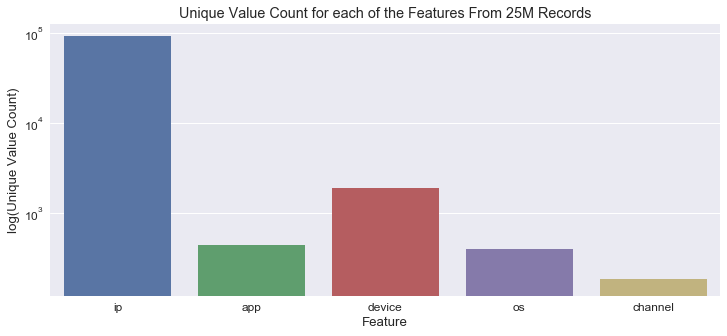

In [141]:
# Plot the Unique Value Count for each of the Features
plt.figure(figsize=(12, 5))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train_df[col].unique()) for col in cols]
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(Unique Value Count)', title='Unique Value Count for each of the Features From 25M Records')
plt.show()

### 11. Feature Engineering

As the data is spread across just few days, the day, month and year in the `click_time` doesn't add much value. So, we will extract `hour` and `minute` and use them for building our model.

In [174]:
# Extract Hour and Minute from click_time
train_df['hour']    = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['minute']    = pd.to_datetime(train_df.click_time).dt.minute.astype('uint8')

# Drop click_time and attributed_time
train_df = train_df.drop(['click_time', 'attributed_time'], axis=1)
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000000 entries, 0 to 24999999
Data columns (total 8 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint8
hour             uint8
minute           uint8
dtypes: uint16(4), uint32(1), uint8(3)
memory usage: 357.6 MB
None


In [175]:
# Use Group By Transformation to create new Features
print('grouping by ip-app combination [count]')
gp = train_df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()

print('grouping by ip-app-os combination [count]')
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

print('grouping by ip-app-channel combination [count]')
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'channel'])[['os']].count().reset_index().rename(index=str, columns={'os': 'ip_app_channel_count'})
train_df = train_df.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()

print('grouping by ip-app-device combination [count]')
gp = train_df[['ip','app', 'device', 'channel']].groupby(by=['ip', 'app', 'device'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_device_count'})
train_df = train_df.merge(gp, on=['ip','app', 'device'], how='left')
del gp
gc.collect()

grouping by ip-app combination [count]
grouping by ip-app-os combination [count]
grouping by ip-app-channel combination [count]
grouping by ip-app-device combination [count]


112

In [176]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000000 entries, 0 to 24999999
Data columns (total 12 columns):
ip                      uint32
app                     uint16
device                  uint16
os                      uint16
channel                 uint16
is_attributed           uint8
hour                    uint8
minute                  uint8
ip_app_count            int64
ip_app_os_count         int64
ip_app_channel_count    int64
ip_app_device_count     int64
dtypes: int64(4), uint16(4), uint32(1), uint8(3)
memory usage: 1.3 GB
None


### 12. Model Building

In [191]:
# Do the Train and Validation Split
VALIDATION_SIZE=2500000 #2.5M
TRAIN_SIZE = 25000000 #25M

train = train_df[:(TRAIN_SIZE-VALIDATION_SIZE)]
val = train_df.iloc[(TRAIN_SIZE-VALIDATION_SIZE):TRAIN_SIZE]

X_train = train.drop(['is_attributed'], axis=1)
y_train = train['is_attributed']

X_val = val.drop(['is_attributed'], axis=1)
y_val = val['is_attributed']

In [192]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22500000 entries, 0 to 22499999
Data columns (total 11 columns):
ip                      uint32
app                     uint16
device                  uint16
os                      uint16
channel                 uint16
hour                    uint8
minute                  uint8
ip_app_count            int64
ip_app_os_count         int64
ip_app_channel_count    int64
ip_app_device_count     int64
dtypes: int64(4), uint16(4), uint32(1), uint8(2)
memory usage: 1.1 GB
None


In [193]:
print(X_val.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500000 entries, 22500000 to 24999999
Data columns (total 11 columns):
ip                      uint32
app                     uint16
device                  uint16
os                      uint16
channel                 uint16
hour                    uint8
minute                  uint8
ip_app_count            int64
ip_app_os_count         int64
ip_app_channel_count    int64
ip_app_device_count     int64
dtypes: int64(4), uint16(4), uint32(1), uint8(2)
memory usage: 128.7 MB
None


In [194]:
predictors = ['app', 'device', 'os', 'channel', 'hour', 'minute', 'ip_app_count', 'ip_app_os_count', 'ip_app_channel_count', 'ip_app_device_count']
categorical = ['app', 'device', 'os', 'channel', 'hour', 'minute']

In [195]:
# Set lgb Parameters
metrics = 'auc'
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':metrics,
        'learning_rate': 0.05,
        'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'nthread': 4,
        'verbose': 0,
        'scale_pos_weight':99.7, # because training data is extremely unbalanced 
        'metric':metrics
}

In [210]:
# Build lgb Model
xgtrain = lgb.Dataset(X_train[predictors].values, label=y_train, feature_name=predictors, categorical_feature=categorical)
xgvalid = lgb.Dataset(X_val[predictors].values, label=y_val, feature_name=predictors, categorical_feature=categorical)

evals_results = {}

model_lgb     = lgb.train(lgb_params, xgtrain, valid_sets=[xgtrain, xgvalid], 
                          valid_names=['train','valid'], 
                           evals_result=evals_results, 
                           num_boost_round=200,
                           early_stopping_rounds=20,
                           verbose_eval=10, feval=None)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 20 rounds.
[10]	train's auc: 0.956977	valid's auc: 0.976404
[20]	train's auc: 0.958553	valid's auc: 0.976787
[30]	train's auc: 0.959691	valid's auc: 0.977425
[40]	train's auc: 0.9631	valid's auc: 0.979331
[50]	train's auc: 0.965363	valid's auc: 0.980409
[60]	train's auc: 0.966618	valid's auc: 0.980856
[70]	train's auc: 0.967496	valid's auc: 0.980978
[80]	train's auc: 0.96857	valid's auc: 0.981246
[90]	train's auc: 0.969054	valid's auc: 0.981702
[100]	train's auc: 0.969637	valid's auc: 0.981964
[110]	train's auc: 0.970109	valid's auc: 0.982243
[120]	train's auc: 0.970559	valid's auc: 0.982519
[130]	train's auc: 0.970958	valid's auc: 0.982658
[140]	train's auc: 0.971248	valid's auc: 0.982849
[150]	train's auc: 0.971496	valid's auc: 0.982954
[160]	train's auc: 0.971779	valid's auc: 0.983146
[170]	train's auc: 0.971979	valid's auc: 0.983254
[180]	train's auc: 0.972284	valid's auc: 0.983415
[190]	train's auc: 0.972527	valid's auc: 0.983613


Features Importance
                feature       gain  split
0                   app  69.448162    310
6          ip_app_count  11.752486     95
3               channel  11.718092    400
9   ip_app_device_count   3.834624     34
2                    os   2.067944    186
1                device   0.584978     62
7       ip_app_os_count   0.399658     48
4                  hour   0.067332     23
5                minute   0.064405     30
8  ip_app_channel_count   0.062320     12


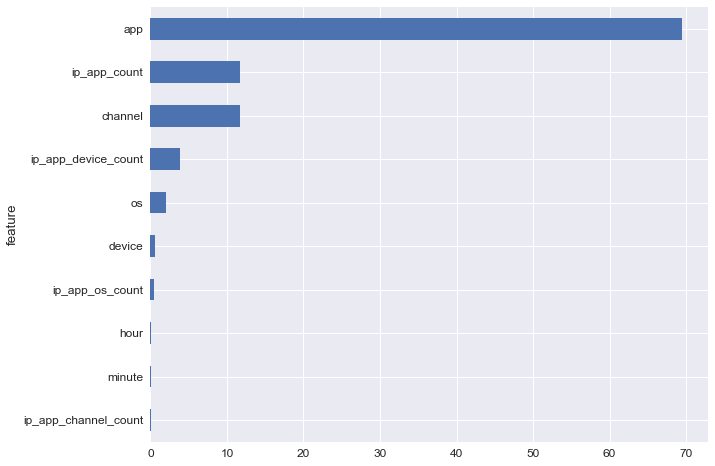

In [197]:
# Show Features Importance
print("Features Importance")
gain = model_lgb.feature_importance('gain')
ft = pd.DataFrame({'feature':model_lgb.feature_name(), 
                   'split':model_lgb.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(ft.head(10))

plt.figure()
ft = ft.sort_values('gain', ascending=True)
ft[['feature','gain']].head(50).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(10, 8))
plt.show()

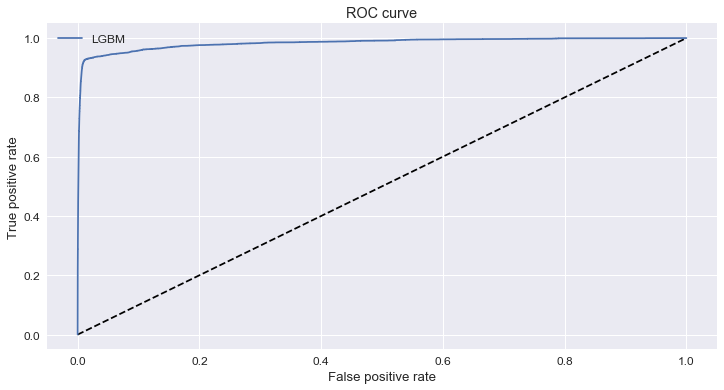

In [201]:
fpr_rf, tpr_rf, _ = roc_curve(y_val, model_lgb.predict(X_val[predictors]))

# Plot the ROC Curve
plt.figure(1)
plt.figure(figsize=(12, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='LGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 13. Process Test Data

In [202]:
# Extract Hour and Minute from click_time
test_df['hour']    = pd.to_datetime(test_df.click_time).dt.hour.astype('uint8')
test_df['minute']    = pd.to_datetime(test_df.click_time).dt.minute.astype('uint8')

# Drop click_time
test_df = test_df.drop(['click_time'], axis=1)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 8 columns):
click_id    uint32
ip          uint32
app         uint16
device      uint16
os          uint16
channel     uint16
hour        uint8
minute      uint8
dtypes: uint16(4), uint32(2), uint8(2)
memory usage: 322.6 MB
None


In [203]:
# Use Group By Transformation to create new Features
print('grouping by ip-app combination [count]')
gp = test_df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
test_df = test_df.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()

print('grouping by ip-app-os combination [count]')
gp = test_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
test_df = test_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

print('grouping by ip-app-channel combination [count]')
gp = test_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'channel'])[['os']].count().reset_index().rename(index=str, columns={'os': 'ip_app_channel_count'})
test_df = test_df.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()

print('grouping by ip-app-device combination [count]')
gp = test_df[['ip','app', 'device', 'channel']].groupby(by=['ip', 'app', 'device'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_device_count'})
test_df = test_df.merge(gp, on=['ip','app', 'device'], how='left')
del gp
gc.collect()

grouping by ip-app combination [count]
grouping by ip-app-os combination [count]
grouping by ip-app-channel combination [count]
grouping by ip-app-device combination [count]


112

In [204]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18790469 entries, 0 to 18790468
Data columns (total 12 columns):
click_id                uint32
ip                      uint32
app                     uint16
device                  uint16
os                      uint16
channel                 uint16
hour                    uint8
minute                  uint8
ip_app_count            int64
ip_app_os_count         int64
ip_app_channel_count    int64
ip_app_device_count     int64
dtypes: int64(4), uint16(4), uint32(2), uint8(2)
memory usage: 1.0 GB
None


In [205]:
# Prepare for Submission
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id']
print("Sub dimension "    + str(sub.shape))

Sub dimension (18790469, 1)


In [206]:
print("Predicting...")
sub['is_attributed'] = model_lgb.predict(test_df[predictors])
print("Writing...")
sub.to_csv('submission.csv.gz',index=False,compression='gzip')
print("Done...")

Predicting...
Writing...
Done...


### References

- https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection
- https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/kernels
- https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion
- http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
- https://lightgbm.readthedocs.io/en/latest/
- http://www.jmlr.org/papers/volume15/oentaryo14a/oentaryo14a.pdf